# Visualizing model errors


This notebook shows examples to prove that misclassifications happen when two dishes look nearly identical.

This proves that it has learned to recognize real food features and textures rather than making random guesses

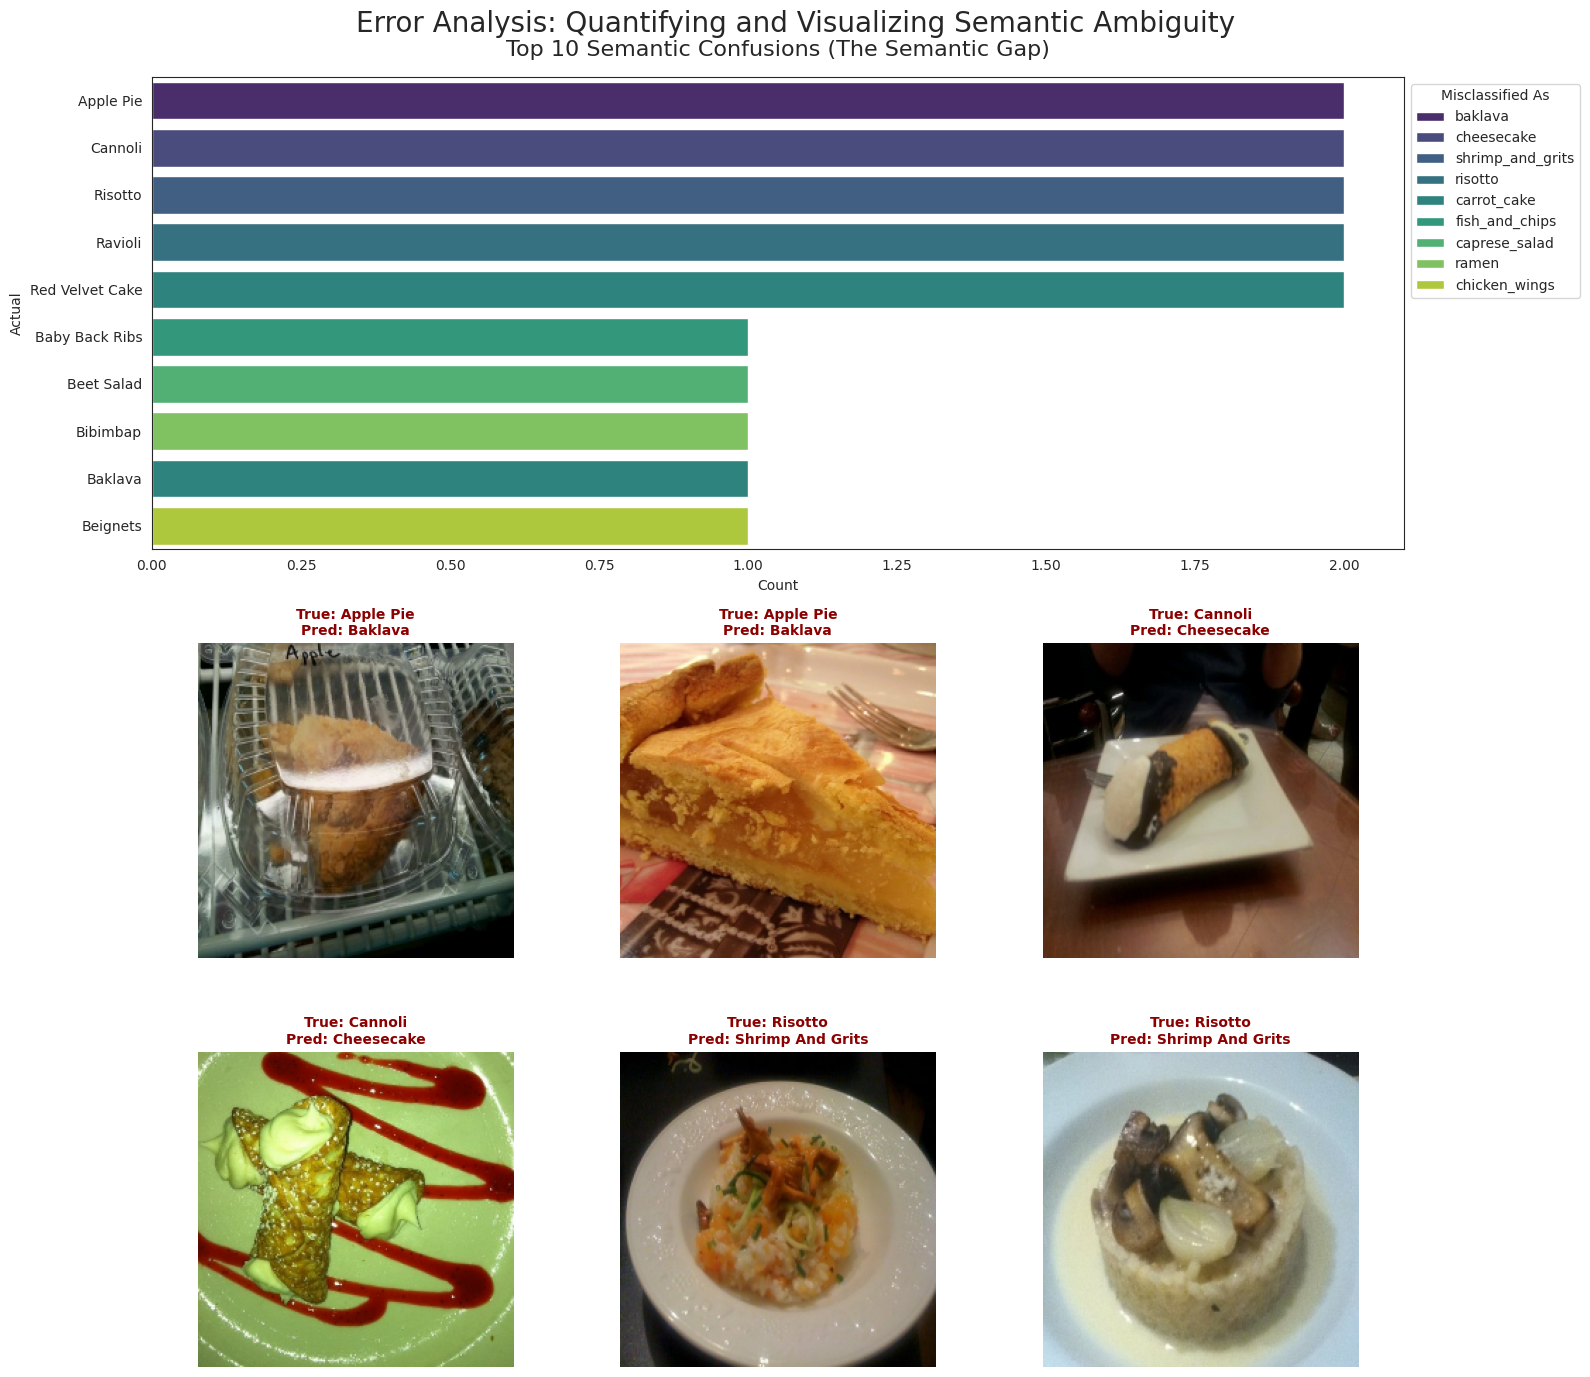

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as mticker

all_images, y_true, y_pred = [], [], []

for images, labels in val_ds.take(40):
    preds = model.predict(images, verbose=0)
    preds_idx = np.argmax(preds, axis=1)

    all_images.extend(images.numpy())
    y_true.extend(labels.numpy())
    y_pred.extend(preds_idx)

num_classes = len(class_names)
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

error_list = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j and cm[i, j] > 0:
            error_list.append({
                'Actual_Idx': i, 'Predicted_Idx': j,
                'Actual': class_names[i], 'Predicted': class_names[j],
                'Count': cm[i, j]
            })

df_errors = pd.DataFrame(error_list).sort_values(by='Count', ascending=False)
top_10_errors = df_errors.head(10)

top_3_pairs = top_10_errors.head(3)
examples_to_plot = []

for _, row in top_3_pairs.iterrows():
    found_count = 0
    for k in range(len(y_true)):
        if y_true[k] == row['Actual_Idx'] and y_pred[k] == row['Predicted_Idx']:
            examples_to_plot.append({
                'img': all_images[k],
                'actual': row['Actual'].replace('_', ' ').title(),
                'pred': row['Predicted'].replace('_', ' ').title()
            })
            found_count += 1
        if found_count >= 2: break

num_examples = len(examples_to_plot)
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 3, height_ratios=[1.5, 1, 1])

ax_bar = fig.add_subplot(gs[0, :])
sns.barplot(data=top_10_errors, x='Count', y='Actual', hue='Predicted', dodge=False, palette="viridis", ax=ax_bar)

ax_bar.yaxis.set_major_locator(mticker.FixedLocator(ax_bar.get_yticks()))
ax_bar.set_yticklabels([label.get_text().replace('_', ' ').title() for label in ax_bar.get_yticklabels()])

ax_bar.set_title("Top 10 Semantic Confusions (The Semantic Gap)", fontsize=16, pad=15)
ax_bar.legend(title="Misclassified As", bbox_to_anchor=(1, 1), loc='upper left')

for idx, ex in enumerate(examples_to_plot):
    row = (idx // 3) + 1
    col = idx % 3

    inner_ax = fig.add_subplot(gs[row, col])
    inner_ax.imshow(ex['img'].astype("uint8"))
    inner_ax.set_title(f"True: {ex['actual']}\nPred: {ex['pred']}", color='darkred', fontsize=10, fontweight='bold')
    inner_ax.axis('off')

plt.suptitle("Error Analysis: Quantifying and Visualizing Semantic Ambiguity", fontsize=20, y=0.98)
plt.tight_layout()
plt.show()

# Model reliability

This analysis verifies that the model is showing high confidence when correct and significantly lower confidence when making mistakes.

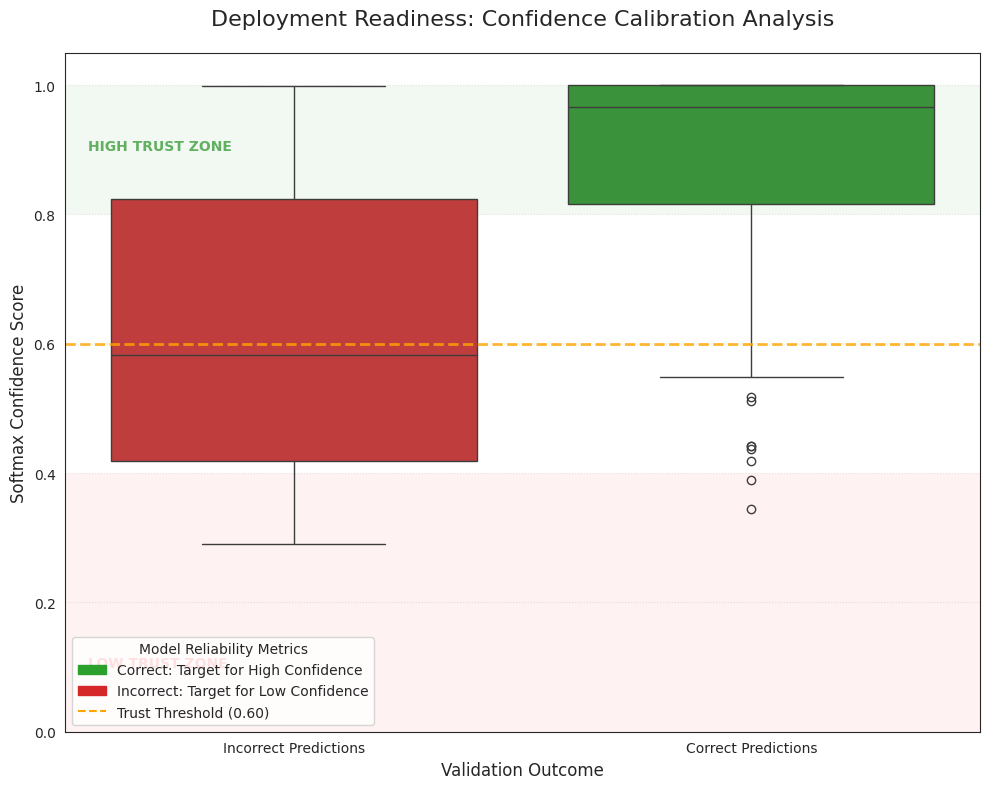

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

confidences = []
results = []

for imgs, lbls in val_ds.take(15):
    preds = model.predict(imgs, verbose=0)
    for i in range(len(imgs)):
        pred_idx = np.argmax(preds[i])
        conf = preds[i][pred_idx]
        confidences.append(conf)
        results.append("Correct Predictions" if pred_idx == lbls[i] else "Incorrect Predictions")

plt.figure(figsize=(10, 8))
sns.set_style("white")

colors = {"Correct Predictions": "#2ca02c", "Incorrect Predictions": "#d62728"}
ax = sns.boxplot(x=results, y=confidences, hue=results, palette=colors, dodge=False)

plt.axhline(y=0.60, color='orange', linestyle='--', linewidth=2, alpha=0.8)

correct_patch = mpatches.Patch(color='#2ca02c', label='Correct: Target for High Confidence')
incorrect_patch = mpatches.Patch(color='#d62728', label='Incorrect: Target for Low Confidence')
threshold_line = plt.Line2D([0], [0], color='orange', linestyle='--', label='Trust Threshold (0.60)')

plt.legend(handles=[correct_patch, incorrect_patch, threshold_line],
           title="Model Reliability Metrics",
           loc='lower left',
           fontsize=10,
           frameon=True)

plt.axhspan(0.8, 1.0, facecolor='green', alpha=0.05) # High Trust Zone
plt.axhspan(0.0, 0.4, facecolor='red', alpha=0.05)   # Low Trust Zone

plt.text(-0.45, 0.9, "HIGH TRUST ZONE", color="green", fontsize=10, fontweight='bold', alpha=0.6)
plt.text(-0.45, 0.1, "LOW TRUST ZONE", color="red", fontsize=10, fontweight='bold', alpha=0.6)

plt.title("Deployment Readiness: Confidence Calibration Analysis", fontsize=16, pad=20)
plt.ylabel("Softmax Confidence Score", fontsize=12)
plt.xlabel("Validation Outcome", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()